In [177]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from typing import Dict, Union
from typing import Optional, Tuple
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import shap
import joblib

In [178]:
TARGET_FEATURES = ['is_churn', 'is_keep','is_upgrade', 'churn_target', 'multiclass_target', 'churn_target_names', 'multiclass_target_names', 'churn_target']
IGNORE_FEATURES = ['gym', 'user', 'communication_date', 'heuristic_prediction']
TARGET = 'churn_target'
MULTI_CLASS_TARGET = "multiclass_target"

# Load data and config

In [427]:
import joblib
import pandas as pd

# Load model configuration
CONFIG = joblib.load("model/model_config.bin")
COLS_TO_INPUT = CONFIG["cols_to_input"]
CATEGORICAL_FEATURES = CONFIG["categorical_features"]
FEATURES = CONFIG["features"]

best_params = joblib.load("model/xgb_params.bin")

# Load processed data
X_train_feats = pd.read_parquet("data/X_train_feats.parquet")
y_train = pd.read_parquet("data/y_train_feats.parquet").iloc[:, 0]

X_test_feats = pd.read_parquet("data/X_test_feats.parquet")
y_test = pd.read_parquet("data/y_test_feats.parquet").iloc[:, 0]

# Data process and feature engineering  submit file

In [428]:
from helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [429]:
import joblib

small_categories = joblib.load("model/small_categories.bin")
small_categories

Index(['dance', 'yoga', 'run', 'personal'], dtype='object', name='gym_category')

In [430]:
submission_data = pd.read_excel('../data/raw/submission.xlsx')

In [431]:
submission_data = preprocessing(submission_data,test=True)
submission_data.head()

,user,gym,user_plan,user_last_60_days_visits,user_days_since_first_billing,gym_category,user_lifetime_visits,user_days_since_first_visit,user_lifetime_visit_share,user_days_since_first_gym_visit,...,gym_last_60_days_visits,gym_days_since_first_visit,months_usage,user_last_60_days_visit_share,user_age,years_usage,user_engagement,gym_visit_frequency,user_visit_frequency,user_age_group
0,31261,522705,Silver,16.0,1450,not found,86,1450,3.255814e+16,90,...,394,172,32,8.125000e+03,71,2.666667,2.687500,6.566667,0.266667,6
1,31262,522705,Silver,12.0,946,not found,40,903,7.500000e+01,48,...,394,172,26,2.500000e-01,32,2.166667,1.538462,6.566667,0.200000,2
2,31263,512514,Silver,4.0,1079,bodybuilding,202,811,1.980198e+16,219,...,1052,246,33,5.000000e-01,44,2.750000,6.121212,17.533333,0.066667,3
3,31264,529403,Basic I,28.0,1100,bodybuilding,185,1097,1.621622e+16,93,...,4744,137,22,7.142857e+15,63,1.833333,8.409091,79.066667,0.466667,5
4,31265,502599,Silver,10.0,108,swim,28,87,3.571429e+15,49,...,830,288,6,1.000000e-01,65,0.500000,4.666667,13.833333,0.166667,6


In [432]:
FEATURES = get_features(submission_data, TARGET_FEATURES, IGNORE_FEATURES)
NUMERIC_FEATURES = sorted(get_numerical_features(submission_data[FEATURES]))
CATEGORICAL_FEATURES = sorted(get_categorical_features(submission_data[FEATURES]))
USER_FEATURES = [k for k in NUMERIC_FEATURES if "user" in k]
USER_FEATURES = filter_list(USER_FEATURES, ['user_age_group'])
# FEATURES

In [433]:
submission_data = feat_engineering(submission_data, small_categories, NUMERIC_FEATURES, USER_FEATURES)
submission_data.shape
COLS_TO_INPUT

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


Index(['user_days_since_first_billing', 'user_last_60_days_visits',
       'user_lifetime_visits', 'user_engagement', 'user_visit_frequency',
       'last_60_user_visit_months_usage_ratio',
       'last_60_user_visit_share_months_usage_ratio',
       'last_60_user_visit_frequency', 'user_days_since_first_billing_log',
       'user_engagement_log', 'user_last_60_days_visits_log',
       'user_lifetime_visits_log', 'user_visit_frequency_log',
       'last_60_user_visit_months_log_usage_ratio',
       'last_60_user_visit_share_months_log_usage_ratio', 'gym_user_age_std',
       'gym_user_age_var', 'gym_user_age_skew', 'gym_user_age_kurtosis',
       'gym_user_days_since_first_billing_mean',
       'gym_user_days_since_first_billing_max',
       'gym_user_days_since_first_billing_median',
       'gym_user_days_since_first_billing_average',
       'gym_user_days_since_first_billing_std',
       'gym_user_days_since_first_billing_var',
       'gym_user_days_since_first_billing_ptp',
       '

In [434]:
FEATURES_TRANSFORMED = get_features(submission_data, TARGET_FEATURES, IGNORE_FEATURES)
FEATURES_TRANSFORMED = filter_list(FEATURES_TRANSFORMED, ['gym_silver_+_revenue', 'gym_free_revenue'])

In [435]:
submission_data['gym_user_age_std']

0       18.463022
1       18.463022
2       16.964060
3       17.585602
4       18.041286
          ...    
5551    17.964951
5552    17.522115
5553    17.964951
5554    17.522115
5555    16.831077
Name: gym_user_age_std, Length: 5556, dtype: float64

In [436]:
FEATURES = get_features(submission_data, TARGET_FEATURES, IGNORE_FEATURES)
NUMERIC_FEATURES = sorted(get_numerical_features(submission_data[FEATURES]))
CATEGORICAL_FEATURES = sorted(get_categorical_features(submission_data[FEATURES]))
USER_FEATURES = [k for k in NUMERIC_FEATURES if "user" in k]
USER_FEATURES = filter_list(USER_FEATURES, ['user_age_group'])
# FEATURES

In [437]:
len(FEATURES)

145

# Model fit and predictions to the final ouput

In [438]:
from collections import Counter
# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 4.719


In [439]:
X_train_feats[COLS_TO_INPUT]

,user_days_since_first_billing,user_last_60_days_visits,user_lifetime_visits,user_engagement,user_visit_frequency,last_60_user_visit_months_usage_ratio,last_60_user_visit_share_months_usage_ratio,last_60_user_visit_frequency,user_days_since_first_billing_log,user_engagement_log,...,gym_user_lifetime_visits_var,gym_user_lifetime_visits_ptp,gym_user_lifetime_visits_skew,gym_user_lifetime_visits_kurtosis,gym_user_visit_frequency_average,gym_user_visit_frequency_std,gym_user_visit_frequency_var,gym_user_visit_frequency_ptp,gym_user_visit_frequency_skew,gym_user_visit_frequency_kurtosis
0,1833.0,19.0,94.0,7.230769,0.316667,1.461538,1.461538,0.316667,7.514255,2.107879,...,11391.521527,682.0,1.883859,4.802982,0.346400,0.201834,0.040737,0.833333,0.404377,-0.656815
1,2608.0,2.0,325.0,3.735632,0.033333,0.022989,0.022989,0.033333,7.866722,1.555115,...,42511.967532,NaN,NaN,NaN,0.262319,0.177113,0.031369,0.566667,0.593029,-0.703024
2,271.0,43.0,199.0,22.111111,0.716667,4.777778,4.777778,0.716667,5.605802,3.140314,...,13378.301281,583.0,1.336883,2.031983,0.318824,0.201364,0.040548,0.850000,0.473950,-0.498566
3,729.0,29.0,119.0,5.950000,0.483333,1.450000,1.450000,0.483333,6.593045,1.938742,...,5957.907143,288.0,0.524510,-0.702617,0.327315,0.231529,0.053606,0.766667,0.435596,-0.813377
4,684.0,8.0,78.0,7.090909,0.133333,0.727273,0.727273,0.133333,6.529419,2.090741,...,5460.721843,382.0,1.833760,3.364176,0.228896,0.183191,0.033559,0.783333,0.897420,0.214297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,90.0,1.0,1.0,0.250000,0.016667,0.250000,0.250000,0.016667,4.510860,0.223144,...,3975.702391,450.0,2.554993,9.329322,0.175935,0.152764,0.023337,0.750000,1.243936,1.273949
24909,25.0,4.0,4.0,2.000000,0.066667,2.000000,2.000000,0.066667,3.258097,1.098612,...,5443.428896,NaN,NaN,NaN,0.382995,0.210276,0.044216,0.933333,0.176123,-0.770708
24910,19.0,1.0,1.0,1.000000,0.016667,1.000000,1.000000,0.016667,2.995732,0.693147,...,5443.428896,NaN,NaN,NaN,0.382995,0.210276,0.044216,0.933333,0.176123,-0.770708
24911,56.0,16.0,16.0,5.333333,0.266667,5.333333,5.333333,0.266667,4.043051,1.845827,...,10601.005042,425.0,2.000611,3.815042,0.332381,0.164642,0.027107,0.733333,0.324379,-0.146755


In [440]:
X_train_feats[FEATURES]

,gym_user_days_since_first_visit_average,user_age_group,gym_user_days_since_first_visit_skew,gym_user_visit_frequency_max,gym_user_lifetime_visits_ptp,gym_user_days_since_first_visit_ptp,gym_user_visit_frequency_ptp,gym_user_days_since_first_visit_var,gym_user_lifetime_visit_share_skew,user_plan,...,gym_user_last_60_days_visit_share_average,gyms_5km_log,gym_user_age_skew,gym_user_lifetime_visits_std,user_lifetime_visits,gym_user_lifetime_visit_share_ptp,gym_user_visit_frequency_median,gym_user_days_since_first_billing_mean,gym_user_lifetime_visit_share_sum,gym_user_lifetime_visit_share_median
0,476.177700,4,1.585354,0.850000,682.0,2536,0.833333,190769.482298,2.341096,Silver,...,8.005026e+15,3.583519,-0.006889,106.731071,94.0,6.451613e+16,0.316667,493.372822,2.572665e+18,6.382979e+15
1,594.173913,4,0.858010,0.600000,NaN,1702,0.566667,291111.786561,2.112790,Basic II,...,7.077873e+15,2.079442,-0.376644,206.184305,325.0,4.534884e+16,0.200000,704.826087,1.896597e+17,6.666667e+15
2,498.164706,2,0.852950,0.866667,583.0,1873,0.850000,141667.358592,2.479168,Basic I,...,4.977899e+15,3.761200,0.048306,115.664607,199.0,7.604563e+16,0.300000,534.556863,2.358827e+18,6.521739e+15
3,563.472222,1,0.360828,0.800000,288.0,1487,0.766667,177157.684921,1.600288,Silver,...,5.603551e+15,4.189655,0.118694,77.187480,119.0,3.863636e+16,0.308333,580.428571,2.710370e+17,4.925797e+15
4,391.624573,5,1.081317,0.800000,382.0,2179,0.783333,124237.516106,2.465667,Basic I,...,2.983318e+15,3.332205,-0.049159,73.896697,78.0,6.122449e+16,0.183333,415.300341,1.907229e+18,1.111111e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24908,291.536585,1,1.640270,0.766667,450.0,2007,0.750000,125333.671449,3.222523,Basic I,...,1.406899e+15,1.386294,0.054078,63.053171,1.0,4.802632e+16,0.133333,326.800000,8.210102e+17,1.000000e+00
24909,207.019166,1,2.671144,0.950000,NaN,1724,0.933333,75169.666675,1.870235,Silver,...,7.279720e+15,3.367296,-0.003117,73.779597,4.0,5.882353e+16,0.366667,215.322435,8.165822e+18,5.421687e+15
24910,207.019166,6,2.671144,0.950000,NaN,1724,0.933333,75169.666675,1.870235,Silver,...,7.279720e+15,3.367296,-0.003117,73.779597,1.0,5.882353e+16,0.366667,215.322435,8.165822e+18,5.421687e+15
24911,440.971429,3,1.231113,0.766667,425.0,1513,0.733333,167710.087395,2.671334,Silver,...,6.248368e+15,3.433987,0.044420,102.961182,16.0,4.716981e+16,0.333333,444.228571,2.493240e+17,5.454545e+15


In [441]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), COLS_TO_INPUT),
        ('cat', TargetEncoder(), CATEGORICAL_FEATURES)],remainder='passthrough')

model = XGBClassifier(**best_params)


X_train_transformed = preprocessor.fit_transform(X_train_feats[FEATURES], y_train)
# Fit the pipeline to the training data
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.500527242209161, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005447688009831847,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=660, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [442]:
X_test_transformed = preprocessor.transform(X_test_feats[FEATURES])
test_pred = model.predict_proba(X_test_transformed)[:,1]

Precision-Recall AUC: 0.27123746145771566
classification_report
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      5343
           1       0.25      0.56      0.35      1005

    accuracy                           0.67      6348
   macro avg       0.57      0.63      0.57      6348
weighted avg       0.79      0.67      0.71      6348


Best F1-score: 0.35133457479826197 at threshold 0.18779592216014862


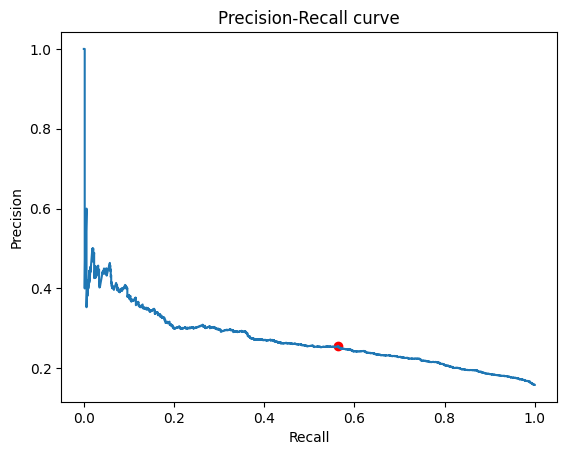

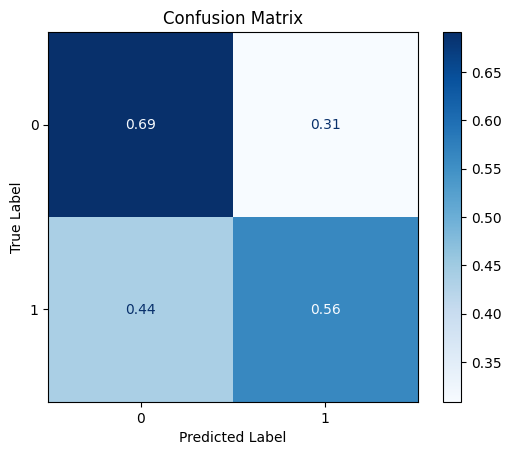

In [443]:
best_thres = evaluate_metrics(y_test, test_pred, normalize='true')

# Analyze predictions
- Evaluate the business impact in test
- Analyze model false-positives and false-negatives

## Churn rate by gym in test

In [331]:
X_train_feats[['gym', 'total_revenue']].drop_duplicates()

,gym,total_revenue
0,0,28671.3
1,1,1377.7
2,3,10174.5
3,4,3596.4
4,5,11690.7
...,...,...
17059,615,119.8
17278,616,59.9
20938,619,79.8
21536,620,59.9


In [456]:
next_upgrade_gym = {
    'Silver': "Silver +",
    'Basic I': "Basic II",
    'Basic II': "Silver",
    'Silver +': "Gold",
    "Free":  "Basic I"
}

plan_price_dict = {
    'Silver': 99.9,
    'Basic I': 39.9,
    'Basic II': 59.9,
    'Silver +': 140.9,
    'Gold': 210, # assumed
    'Free': 0
}

X_test_feats['upgrade_plan'] = X_test_feats.user_plan.map(next_upgrade_gym)
X_test_feats['upgrade_user_plan_price'] = X_test_feats["upgrade_plan"].map(plan_price_dict)

In [452]:
X_test_feats['predict_churn'] = (test_pred > best_thres).astype(int)

new_revenue = X_test_feats.groupby("gym").upgrade_user_plan_price.sum().reset_index(name="upgrade_revenue")
# new_revenue = new_revenue.rename(columns={'upgrade_user_': 'total_revenue'})
X_test_feats['is_churn'] = y_test
total_users = X_test_feats.groupby("gym").user.size().reset_index(name="total_users")
total_churns = X_test_feats.groupby("gym").is_churn.sum().reset_index(name="total_churns")
total_pred_churns = X_test_feats.groupby("gym").predict_churn.sum().reset_index(name="total_pred_churns")
gym_plan = X_test_feats.groupby("gym").upgrade_plan.first().reset_index(name="upgrade_plan")

old_revenue = X_test_feats.groupby("gym").user_plan_price.sum().reset_index(name="current_plan_revenue")

gym_profits = new_revenue.merge(old_revenue,on="gym")
gym_profits = gym_profits.merge(total_users, on="gym")
gym_profits = gym_profits.merge(total_churns, on="gym")
gym_profits = gym_profits.merge(gym_plan, on="gym")
gym_profits = gym_profits.merge(total_pred_churns, on="gym")

gym_profits['final_total_users'] = (gym_profits['total_users'] - gym_profits['total_churns'])
gym_profits['percent_lost_users'] = round(gym_profits['total_churns']/gym_profits['total_users'],2)*100

gym_profits['final_predicted_total_users'] = (gym_profits['total_users'] - gym_profits['total_pred_churns'])
gym_profits['percent_predicted_lost_users'] = round(gym_profits['total_pred_churns']/gym_profits['total_users'],2)*100


gym_profits['total_revenue_real_churn'] = gym_profits.apply(lambda x: plan_price_dict[x['upgrade_plan']]*x['final_total_users'] ,axis=1)
gym_profits['total_revenue_pred_churn'] = gym_profits.apply(lambda x: plan_price_dict[x['upgrade_plan']]*x['final_predicted_total_users'] ,axis=1)

gym_profits['real_profit'] = gym_profits['total_revenue_real_churn'] - gym_profits['current_plan_revenue']
gym_profits['predicted_profit'] = gym_profits['total_revenue_pred_churn'] - gym_profits['current_plan_revenue']

# gym_profits['profit'] = gym_profits['upgrade_revenue'] - gym_profits['current_plan_revenue']
gym_profits['percent_profit_real_churn'] = round(gym_profits['real_profit']/gym_profits['current_plan_revenue'],2)*100
gym_profits['percent_profit_pred_churn'] = round(gym_profits['predicted_profit']/gym_profits['current_plan_revenue'],2)*100

gym_profits = gym_profits[gym_profits.total_users > 10] # does not make sense to upgrade gyms with a small quantity of users

gym_profits['indicate_upgrade'] = (gym_profits.percent_profit_real_churn > 10.0).astype(float)
gym_profits['predicted_indicate_upgrade'] = (gym_profits.percent_profit_pred_churn > 10.0).astype(float)
gym_profits

Total profit if upgrade by gym without consider churn.


,gym,upgrade_revenue,current_plan_revenue,total_users,total_churns,upgrade_plan,total_pred_churns,final_total_users,percent_lost_users,final_predicted_total_users,percent_predicted_lost_users,total_revenue_real_churn,total_revenue_pred_churn,real_profit,predicted_profit,percent_profit_real_churn,percent_profit_pred_churn,indicate_upgrade,predicted_indicate_upgrade
0,2,12099.8,8059.8,202,16,Basic II,39,186,8.0,163,19.0,11141.4,9763.7,3081.6,1703.9,38.0,21.0,1.0,1.0
2,10,1549.9,1098.9,11,0,Silver +,4,11,0.0,7,36.0,1549.9,986.3,451.0,-112.6,41.0,-10.0,1.0,0.0
3,24,1698.3,1018.3,17,0,Silver,0,17,0.0,17,0.0,1698.3,1698.3,680.0,680.0,67.0,67.0,1.0,1.0
4,29,6593.4,3953.4,66,11,Silver,15,55,17.0,51,23.0,5494.5,5094.9,1541.1,1141.5,39.0,29.0,1.0,1.0
5,30,7906.8,5266.8,132,18,Basic II,40,114,14.0,92,30.0,6828.6,5510.8,1561.8,244.0,30.0,5.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,486,2113.5,1498.5,15,1,Silver +,8,14,7.0,7,53.0,1972.6,986.3,474.1,-512.2,32.0,-34.0,1.0,0.0
101,506,658.9,438.9,11,1,Basic II,4,10,9.0,7,36.0,599.0,419.3,160.1,-19.6,36.0,-4.0,1.0,0.0
103,524,1098.9,658.9,11,4,Silver,8,7,36.0,3,73.0,699.3,299.7,40.4,-359.2,6.0,-55.0,0.0,0.0
111,552,778.7,518.7,13,1,Basic II,7,12,8.0,6,54.0,718.8,359.4,200.1,-159.3,39.0,-31.0,1.0,0.0


Real upgrade indication


<Axes: xlabel='indicate_upgrade'>

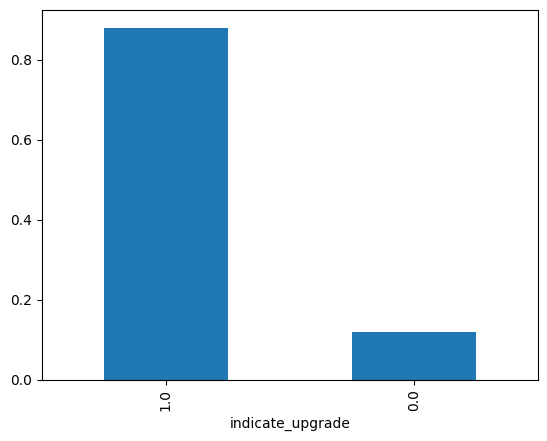

In [454]:
print("Real upgrade indication")
gym_profits.indicate_upgrade.value_counts(normalize=True).plot(kind='bar')

Real upgrade indication


<Axes: xlabel='predicted_indicate_upgrade'>

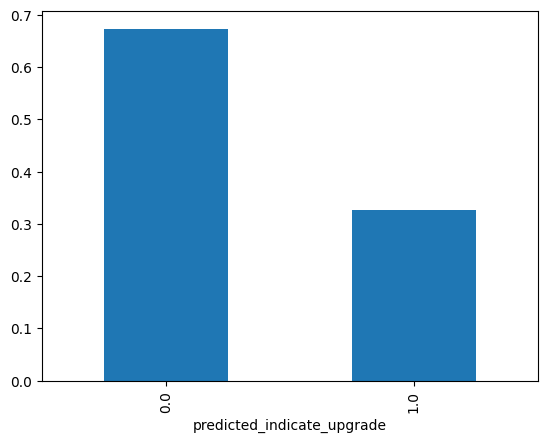

In [455]:
print("Real upgrade indication")
gym_profits.predicted_indicate_upgrade.value_counts(normalize=True).plot(kind='bar')

# Generate final predictions

In [464]:
X_sub_transformed = preprocessor.transform(submission_data[FEATURES_TRANSFORMED])
final_predictions = model.predict_proba(X_sub_transformed)[:,1]

In [468]:
best_thres

0.18779592

In [465]:

submission_data['upgrade_plan'] = submission_data.user_plan.map(next_upgrade_gym)
submission_data['upgrade_user_plan_price'] = submission_data["upgrade_plan"].map(plan_price_dict)

In [480]:
submission_data['predict_churn'] = (final_predictions > best_thres).astype(int)

new_revenue = submission_data.groupby("gym").upgrade_user_plan_price.sum().reset_index(name="upgrade_revenue")
# new_revenue = new_revenue.rename(columns={'upgrade_user_': 'total_revenue'})
total_users = submission_data.groupby("gym").user.size().reset_index(name="total_users")
total_pred_churns = submission_data.groupby("gym").predict_churn.sum().reset_index(name="total_pred_churns")
gym_plan = submission_data.groupby("gym").upgrade_plan.first().reset_index(name="upgrade_plan")

old_revenue = submission_data.groupby("gym").user_plan_price.sum().reset_index(name="current_plan_revenue")

gym_profits = new_revenue.merge(old_revenue,on="gym")
gym_profits = gym_profits.merge(total_users, on="gym")
gym_profits = gym_profits.merge(gym_plan, on="gym")
gym_profits = gym_profits.merge(total_pred_churns, on="gym")

gym_profits['final_predicted_total_users'] = (gym_profits['total_users'] - gym_profits['total_pred_churns'])
gym_profits['percent_predicted_lost_users'] = round(gym_profits['total_pred_churns']/gym_profits['total_users'],2)*100


gym_profits['total_revenue_pred_churn'] = gym_profits.apply(lambda x: plan_price_dict[x['upgrade_plan']]*x['final_predicted_total_users'] ,axis=1)

gym_profits['predicted_profit'] = gym_profits['total_revenue_pred_churn'] - gym_profits['current_plan_revenue']

gym_profits['percent_profit_pred_churn'] = round(gym_profits['predicted_profit']/gym_profits['current_plan_revenue'],2)*100

gym_profits = gym_profits[gym_profits.total_users > 10] # does not make sense to upgrade gyms with a small quantity of users

gym_profits['predicted_indicate_upgrade_profit'] = (gym_profits.percent_profit_pred_churn > 10.0).astype(float)
gym_profits['predicted_indicate_upgrade_users'] = (gym_profits.percent_predicted_lost_users < 20.0).astype(float)
gym_profits

,gym,upgrade_revenue,current_plan_revenue,total_users,upgrade_plan,total_pred_churns,final_predicted_total_users,percent_predicted_lost_users,total_revenue_pred_churn,predicted_profit,percent_profit_pred_churn,predicted_indicate_upgrade_profit,predicted_indicate_upgrade_users
0,10833,1549.9,1098.9,11,Silver +,2,9,18.0,1268.1,169.2,15.0,1.0,1.0
1,43418,2297.7,1377.7,23,Silver,2,21,9.0,2097.9,720.2,52.0,1.0,1.0
2,66010,6199.6,4395.6,44,Silver +,12,32,27.0,4508.8,113.2,3.0,0.0,0.0
5,78835,5072.4,3596.4,36,Silver +,4,32,11.0,4508.8,912.4,25.0,1.0,1.0
6,90959,4672.2,3112.2,78,Basic II,24,54,31.0,3234.6,122.4,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,529679,4227.0,2997.0,30,Silver +,6,24,20.0,3381.6,384.6,13.0,1.0,0.0
93,531216,9581.2,6793.2,68,Silver +,16,52,24.0,7326.8,533.6,8.0,0.0,0.0
94,531392,3099.8,2197.8,22,Silver +,12,10,55.0,1409.0,-788.8,-36.0,0.0,0.0
95,531428,3099.8,2197.8,22,Silver +,4,18,18.0,2536.2,338.4,15.0,1.0,1.0


Upgrade indication by profit


<Axes: xlabel='predicted_indicate_upgrade_profit'>

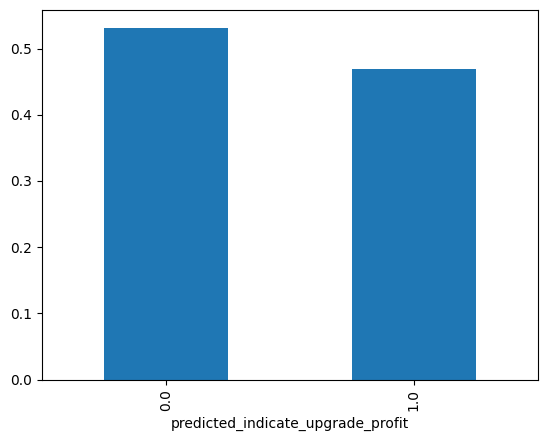

In [482]:
print("Upgrade indication by profit")
gym_profits.predicted_indicate_upgrade_profit.value_counts(normalize=True).plot(kind='bar')

Upgrade indication by user churn rate


<Axes: xlabel='predicted_indicate_upgrade_users'>

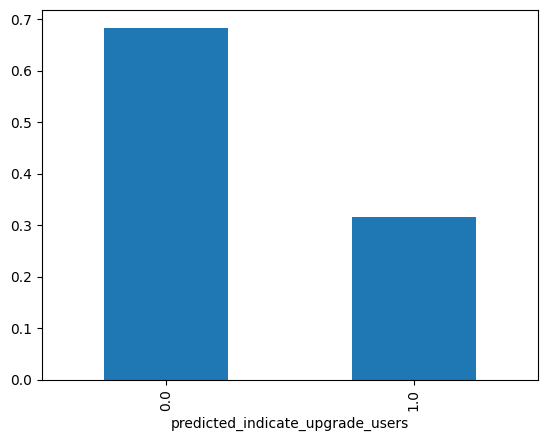

In [483]:
print("Upgrade indication by user churn rate")
gym_profits.predicted_indicate_upgrade_users.value_counts(normalize=True).plot(kind='bar')

In [484]:
joblib.dump(final_predictions, "model/final_predictions.bin")

['model/final_predictions.bin']

# Model interpretation

TODO: give the pros and cons of false-positive vs false-negatives, precision vs recall

In [485]:
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=list(X_train_feats[FEATURES]))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


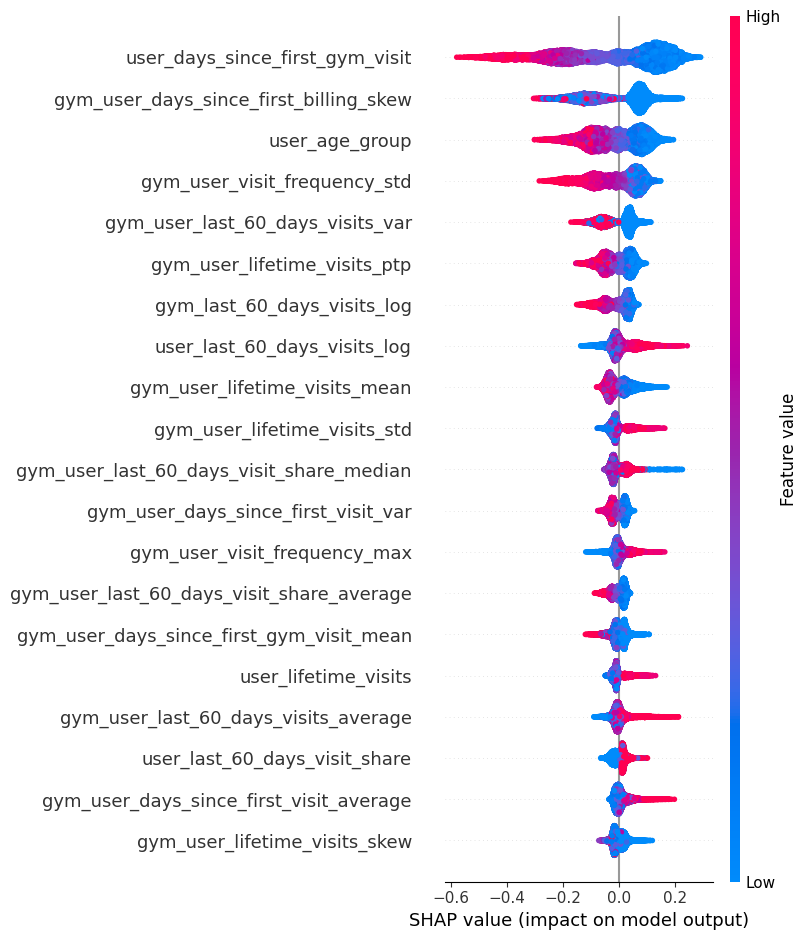

In [486]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train_transformed_df)
f = plt.figure()
shap.summary_plot(shap_values, X_train_transformed_df)
f.savefig("viz/summary_plot1.png", bbox_inches='tight', dpi=600)

In [41]:

# # Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
# shap.initjs()

# # Write in a function
# def shap_plot(j, model, df):
#     explainerModel = shap.TreeExplainer(model)
#     shap_values_Model = explainerModel.shap_values(df)
#     p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], df.iloc[[j]])
#     return(p)